# Practical 2

Name: Tucholski, Parchem, Würzberg

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.
Let's start with a bit of exploration.

### Tasks 1.1: Dataset Exploration 
- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
import os, sys
drive.mount("/content/drive")
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Machine Learning/02')
os. chdir('/content/drive/MyDrive/Colab Notebooks/Machine Learning/02')

file = 'data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Number of samples: " + str(len(X_all)))
print("Number of features: " + str(len(X_all[0])))
labels, lc = np.unique(t_all, return_counts=True)
print("Number of labels: " + str(len(lc)) + " with counts " + str(lc))
print("Value range of features: " + str(np.min(X_all)) + " to " + str(np.max(X_all)))
rows = cols = 8
feature = 0
fig, axs = plt.subplots(rows, cols)
for i in range(0,rows):
    for j in range(0,cols):
        axs[i,j].scatter(range(10), X_all[::11,feature])
        axs[i,j].set_title(df.columns[feature])
        axs[i,j].set_xlabel(df.columns[feature])
        axs[i,j].set_ylabel("Value")
        feature += 1
fig.set_size_inches(48,48)
plt.show()

plt.plot(np.var(X_all, axis=0))
plt.xlabel("Feature")
plt.ylabel("Variance")

Number of samples: 105
Number of features: 64
Number of labels: 2 with counts [52 53]
Value range of features: 0.06067111099999999 to 7.4640702139999995


Text(0, 0.5, 'Variance')

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [ ]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

    test_idx = idx_shuffled[:int(X.shape[0]*frac)]
    train_idx = idx_shuffled[int(X.shape[0]*frac):X.shape[0]]

    X_test = X[test_idx]
    y_test = y[test_idx]
    print('Test set shapes (X and y)', X_test.shape, y_test.shape)

    X_train = X[train_idx]
    y_train = y[train_idx]
    print('Training set shapes (X and y):', X_train.shape, y_train.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
# Standardization
def preprocess(X):
    m = len(X[0,:])
    d = X.copy()
    for i in range(m):
        d[:,i] = (d[:,i] - d[:,i].mean()) / d[:,i].std()
    return d

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

** Task 2.1 ***

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

In [ ]:
def compute_lda_weights(X, y):
    length = X.shape[1]
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)

    between_class_feature_means = []
    for i in unique_classes:
        between_class_feature_means.append(np.array((X[y==i].mean(axis=0))))

    sw_scatter_matrix = np.zeros((length,length))
    for i in range(num_classes):    
        s = np.zeros((length,length))
        mc, x_c = between_class_feature_means[i], X[y==unique_classes[i]]
        sw_scatter_matrix += (x_c - mc).T.dot((x_c - mc))

    feature_means = X.mean(axis=0)
    sb_scatter_matrix = np.zeros((length,length))
    for i in range(num_classes):
        n = X[y==unique_classes[i]].shape[0]
        mc, m = between_class_feature_means[i].reshape(length,1), feature_means.reshape(length,1)
        sb_scatter_matrix += n * (mc - m).dot((mc - m).T)
        
    #eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(sw_scatter_matrix).dot(sb_scatter_matrix))
    #pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
    #pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
    #print(eigen_values.shape, eigen_vectors.shape)
    #for pair in pairs:
    #    print(pair[0])
    #eigen_value_sums = sum(eigen_values)
    #print('Variances')
    #for i, pair in  enumerate(pairs):
    #    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))
    
    #weights = np.hstack((pairs[0][1].reshape(length,1), pairs[1][1].reshape(length,1))).real
    #weights = pairs[0][1].reshape(length,1)
    #for i in range(1,len(pairs)):
    #    weights = np.hstack((weights, pairs[i][1].reshape(length,1))).real

    w = np.linalg.inv(sw_scatter_matrix).dot(between_class_feature_means[1]-between_class_feature_means[0])

    return between_class_feature_means[0], between_class_feature_means[1], between_class_feature_means[1]-between_class_feature_means[0], w

Test set shapes (X and y) (31, 64) (31,)
Training set shapes (X and y): (74, 64) (74,)


Text(0.5, 0, 'predictors')

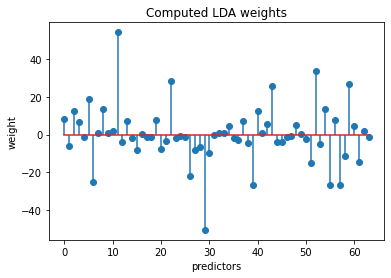

In [ ]:
X, X_test, t, t_test = split_data(X_all, t_all, seed=1)
m0, m1, mdiff, w_lda = compute_lda_weights(X, t)

#w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

### Task 2.3

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
  - Seems so.
- Is there a big difference between training and test data?
  - Yes. For training date is a big gap visible.

(array([1., 0., 1., 0., 1., 3., 1., 2., 1., 1.]),
 array([2.20384499, 2.76432033, 3.32479567, 3.885271  , 4.44574634,
        5.00622168, 5.56669701, 6.12717235, 6.68764769, 7.24812302,
        7.80859836]),
 <a list of 10 Patch objects>)

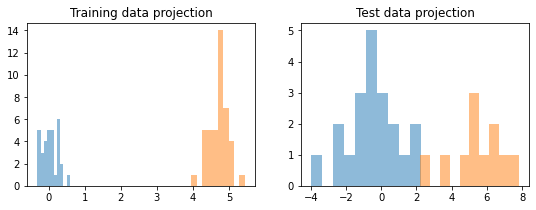

In [ ]:
a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].set_title('Training data projection')
ax[0].hist((X[t==np.unique(t)[0]].dot(w_lda)),label='class 0',alpha=0.5)
ax[0].hist((X[t==np.unique(t)[1]].dot(w_lda)),label='class 1',alpha=0.5)
ax[1].set_title('Test data projection')
ax[1].hist((X_test.dot(w_lda.T))[t_test==np.unique(t_test)[0]],label='class 0',alpha=0.5)
ax[1].hist((X_test.dot(w_lda.T))[t_test==np.unique(t_test)[1]],label='class 1',alpha=0.5)

### Task 2.4 

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

c = 2.378379995870853
Accuracy Trainset:  1.0
Accuracy Testset:  0.967741935483871


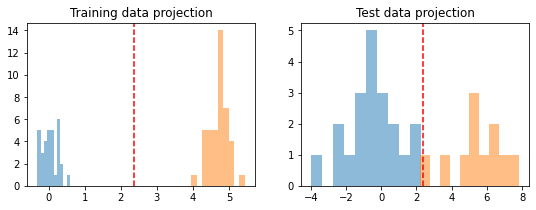

In [ ]:
c = (w_lda * 1/2).dot(m0+m1)
print('c = ' + str(c))
correct = len((X[t==np.unique(t)[0]].dot(w_lda.T))[(X[t==np.unique(t)[0]].dot(w_lda.T))<=c]) + len((X[t==np.unique(t)[1]].dot(w_lda.T))[(X[t==np.unique(t)[1]].dot(w_lda.T))>c])
score = correct/len(t)
print('Accuracy Trainset: ',score)
correct = len((X_test[t_test==np.unique(t_test)[0]].dot(w_lda))[(X_test[t_test==np.unique(t_test)[0]].dot(w_lda))<=c]) + len((X_test[t_test==np.unique(t_test)[1]].dot(w_lda))[(X_test[t_test==np.unique(t_test)[1]].dot(w_lda))>c])
score = correct/len(t_test)
print('Accuracy Testset: ',score)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].set_title('Training data projection')
ax[0].hist((X[t==np.unique(t)[0]].dot(w_lda)),label='class 0',alpha=0.5)
ax[0].hist((X[t==np.unique(t)[1]].dot(w_lda)),label='class 1',alpha=0.5)
ax[0].axvline(c, color='r', linestyle='--')
ax[1].set_title('Test data projection')
ax[1].hist((X_test.dot(w_lda))[t_test==np.unique(t_test)[0]],label='class 0',alpha=0.5)
ax[1].hist((X_test.dot(w_lda))[t_test==np.unique(t_test)[1]],label='class 1',alpha=0.5)
ax[1].axvline(c, color='r', linestyle='--')

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

X_all, t_all = pickle.load(open('data/cnn_features.pickle', 'rb'))

**Task 3.0: Normalize the data**

Make sure the data has has zero mean and variance 1 per feature.

In [ ]:
# Standardization
X_norm = preprocess(X_all)

**Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
Where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  
Hints:  
(a) There is a bias term in logistic regression  
(b) Use a small value for weight init to avoid numerical problems.

2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
def y(X, w, b):
    return sigmoid(X.dot(w)+b)

In [ ]:
def R(y):
    R = np.identity(y.size)
    R = R*(y*(1-y))
    return R

In [ ]:
def irls(X, t):
    w = np.zeros(X.shape[1])
    w = w.reshape(w.size, 1)
    t = np.array(list(map(lambda x: 1 if x else 0, t)))
    t = t.reshape(t.size, 1)
    lr = 0.01 # learning rate
    b = 0.1 # bias

    #after 3 iterations matrix is singular
    for i in range(3):
        y_pred = y(X,w,b)
        w = w - np.linalg.inv(X.T.dot(R(y_pred)).dot(X)).dot((X.T).dot(y_pred-t))
        b = b - lr * np.mean(y_pred-t)
    return w

Test set shapes (X and y) (600, 256) (600,)
Training set shapes (X and y): (1400, 256) (1400,)
Accuracy Testset:  0.895


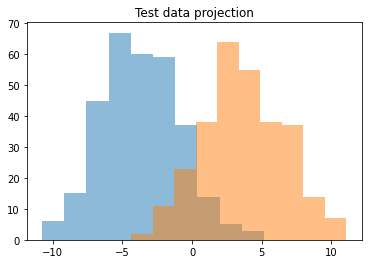

In [ ]:
X, X_test, t, t_test = split_data(X_norm, t_all, seed=1)

w = irls(X, t)

# compute accuracy
x0 = np.array(X_test[t_test==np.unique(t_test)[0]])
x1 = np.array(X_test[t_test==np.unique(t_test)[1]])
c = (w * 1/2).reshape(len(w),).dot(x0.mean(axis=0)+x1.mean(axis=0))
correct = len((x0.dot(w))[(x0.dot(w))<=c]) + len((x1.dot(w))[(x1.dot(w))>c])
score = correct/len(t_test)
print('Accuracy Testset: ',score)

plt.title('Test data projection')
_ = plt.hist((X_test.dot(w))[t_test==np.unique(t_test)[0]],label='class 0',alpha=0.5)
_ = plt.hist((X_test.dot(w))[t_test==np.unique(t_test)[1]],label='class 1',alpha=0.5)

Accuracy:  0.8716666666666667


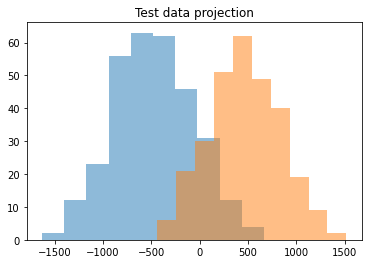

In [ ]:
# Logistic Regression sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics


model = LogisticRegression(penalty='none').fit(X, t)
y_pred = model.predict(X_test)
w = model.coef_[0]
plt.title('Test data projection')
_ = plt.hist((X_test.dot(w))[t_test==np.unique(t_test)[0]],label='class 0',alpha=0.5)
_ = plt.hist((X_test.dot(w))[t_test==np.unique(t_test)[1]],label='class 1',alpha=0.5)

score_noreg = metrics.accuracy_score(t_test, y_pred)
print('Accuracy: ',score_noreg)

**Task 3.2: Logistic Regression with Regularization**

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
  - For small `C` is the regularization the strongest.

2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [ ]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

C = np.linspace(0.02, 1, 25)
y_L1 = []
y_L2 = []
for c in C:
    L1 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    L1.fit(X, t)
    L2 = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    L2.fit(X, t)
    print('C:', c)
    print('L1')
    #print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', L1.score(X_train_std, t))
    print('Test accuracy:', L1.score(X_test_std, t_test))
    y_L1.append(L1.score(X_test_std, t_test))
    print('L2')
    #print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', L2.score(X_train_std, t))
    print('Test accuracy:', L2.score(X_test_std, t_test))
    print('')
    y_L2.append(L2.score(X_test_std, t_test))
w_L1 = L1.coef_[0]
w_L2 = L2.coef_[0]

C: 0.02
L1
Training accuracy: 0.8957142857142857
Test accuracy: 0.8933333333333333
L2
Training accuracy: 0.9478571428571428
Test accuracy: 0.915

C: 0.060833333333333336
L1
Training accuracy: 0.9235714285714286
Test accuracy: 0.91
L2
Training accuracy: 0.9571428571428572
Test accuracy: 0.915

C: 0.10166666666666667
L1
Training accuracy: 0.94
Test accuracy: 0.9133333333333333
L2
Training accuracy: 0.9621428571428572
Test accuracy: 0.9116666666666666

C: 0.1425
L1
Training accuracy: 0.9435714285714286
Test accuracy: 0.9166666666666666
L2
Training accuracy: 0.9664285714285714
Test accuracy: 0.9083333333333333

C: 0.18333333333333332
L1
Training accuracy: 0.9471428571428572
Test accuracy: 0.9133333333333333
L2
Training accuracy: 0.9664285714285714
Test accuracy: 0.9016666666666666

C: 0.22416666666666665
L1
Training accuracy: 0.9492857142857143
Test accuracy: 0.9133333333333333
L2
Training accuracy: 0.9671428571428572
Test accuracy: 0.9033333333333333

C: 0.265
L1
Training accuracy: 0.9528

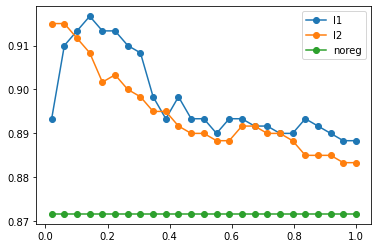

In [ ]:
 regplot = [None, None, None]
 l1_plot, = plt.plot(np.linspace(0.02, 1, 25), y_L1, '-o')
 l1_plot.set_label('l1')
 l2_plot, = plt.plot(np.linspace(0.02, 1, 25), y_L2, '-o')
 l2_plot.set_label('l2')
 noreg_plot, = plt.plot(np.linspace(0.02, 1, 25), [score_noreg]*25, '-o')
 noreg_plot.set_label('noreg')
 plt.legend()
 plt.show()

Text(0.5, 0, 'predictors')

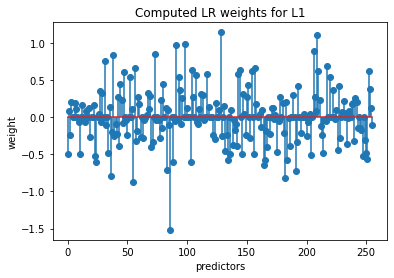

In [ ]:
plt.stem(w_L1.flatten(), use_line_collection=True)
plt.title('Computed LR weights for L1')
plt.ylabel('weight')
plt.xlabel('predictors')

Text(0.5, 0, 'predictors')

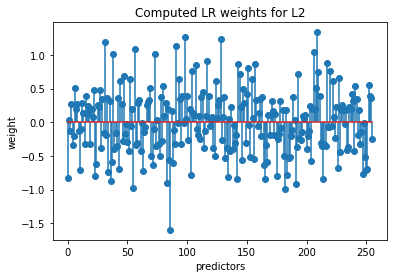

In [ ]:
plt.stem(w_L2.flatten(), use_line_collection=True)
plt.title('Computed LR weights for L2')
plt.ylabel('weight')
plt.xlabel('predictors')